In [ ]:
#import library
from google.colab import drive
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import random

# **Import from drive**

In [ ]:
#import image from drives
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/deep learning"

 Correct_Way			        Incorrect_Way
'deep learning kia '		       'proposal deep learning project.gdoc'
'draft notes codigo decription .gdoc'   Untitled0.ipynb
'Final Report Deep Learning.gdoc'


In [ ]:
#path folder in drive
correct_path = "/content/drive/MyDrive/deep learning/Correct_Way"
incorrect_path = "/content/drive/MyDrive/deep learning/Incorrect_Way"

#check folder image
def load_images(path):
    imgs = []


    if not os.path.isdir(path):
        print(f"folder not found: {path}")
        return imgs

    print(f"I read from: {path}")
    print("folder contents:", os.listdir(path))

    for file in os.listdir(path):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            full_path = os.path.join(path, file)
            img = cv2.imread(full_path)
            if img is None:
                print(f"image not loaded correctly: {full_path}")
            else:
                imgs.append(img)

    print(f"Found {len(imgs)} image in {path}")
    return imgs

#uploead image
correct_imgs = load_images(correct_path)
incorrect_imgs = load_images(incorrect_path)

print("Correct:", len(correct_imgs))
print("Incorrect:", len(incorrect_imgs))

I read from: /content/drive/MyDrive/deep learning/Correct_Way
folder contents: ['image5025.jpg', 'image4974.jpg', 'image4964.jpg', 'image5044.jpg', 'image5024.jpg', 'image5033.jpg', 'image5027.jpg', 'image4989.jpg', 'image5016.jpg', 'image4952.jpg', 'image4970.jpg', 'image5026.jpg', 'image4955.jpg', 'image4956.jpg', 'image5023.jpg', 'image5028.jpg', 'image4983.jpg', 'image5051.jpg', 'image4982.jpg', 'image5034.jpg', 'image5036.jpg', 'image5019.jpg', 'image5047.jpg', 'image4979.jpg', 'image4953.jpg', 'image5022.jpg', 'image5011.jpg', 'image4963.jpg', 'image4966.jpg', 'image4967.jpg', 'image5008.jpg', 'image4973.jpg', 'image4960.jpg', 'image4991.jpg', 'image4988.jpg', 'image4992.jpg', 'image5012.jpg', 'image5038.jpg', 'image5029.jpg', 'image4972.jpg', 'image5000.jpg', 'image4927.jpg', 'image4938.jpg', 'image4886.jpg', 'image4869.jpg', 'image4887.jpg', 'image4836.jpg', 'image4891.jpg', 'image4890.jpg', 'image4834.jpg', 'image4831.jpg', 'image4929.jpg', 'image4946.jpg', 'image4862.jpg', 'i

# **Seeds for reproducibility**

In [ ]:
import random
import numpy as np
import torch


SEED = 9999
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print("Random sample (Python):", random.random())
print("Random sample (NumPy):", np.random.rand())
print("Random sample (PyTorch):", torch.rand(1).item())

Random sample (Python): 0.8347577610922152
Random sample (NumPy): 0.8233890742543671
Random sample (PyTorch): 0.7876027822494507


# **Data**

In [ ]:
#defnition number of image of each dataset
#mix image
random.shuffle(correct_imgs)
random.shuffle(incorrect_imgs)

#number of image for folder
n_correct = len(correct_imgs)
n_incorrect = len(incorrect_imgs)

# from correct folder
n_train_c = int(0.7 * n_correct) #70% training
n_val_c   = int(0.15 * n_correct) #15% validation
n_test_c  = n_correct - n_train_c - n_val_c  #15% test

correct_train = correct_imgs[:n_train_c]
correct_val   = correct_imgs[n_train_c:n_train_c + n_val_c]
correct_test  = correct_imgs[n_train_c + n_val_c:]

#incorrect folder
n_train_i = int(0.7 * n_incorrect) #70% training
n_val_i   = int(0.15 * n_incorrect) #15% validatio
n_test_i  = n_incorrect - n_train_i - n_val_i #15% test

incorrect_train = incorrect_imgs[:n_train_i]
incorrect_val   = incorrect_imgs[n_train_i:n_train_i + n_val_i]
incorrect_test  = incorrect_imgs[n_train_i + n_val_i:]

print("Corrette  -> train:", len(correct_train), "val:", len(correct_val), "test:", len(correct_test))
print("Incorrette-> train:", len(incorrect_train), "val:", len(incorrect_val), "test:", len(incorrect_test))

Corrette  -> train: 2551 val: 546 test: 548
Incorrette-> train: 2551 val: 546 test: 548


In [ ]:
#datset + labels
# TRAIN
X_train = correct_train + incorrect_train
y_train = [1] * len(correct_train) + [0] * len(incorrect_train) #labels

# VALIDATION
X_val = correct_val + incorrect_val
y_val = [1] * len(correct_val) + [0] * len(incorrect_val) #labels

# TEST
X_test = correct_test + incorrect_test
y_test = [1] * len(correct_test) + [0] * len(incorrect_test)

print("TRAIN  ->", len(X_train), "images")
print("VAL    ->", len(X_val),   "images")
print("TEST   ->", len(X_test),  "images")


TRAIN  -> 5102 images
VAL    -> 1092 images
TEST   -> 1096 images


In [ ]:
import torch
import torch.utils.data as data
from torch.utils.data import Dataset
import torchvision.transforms as T
import cv2

# correct format image for MobileNet
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

#definition dataset
class PostureDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]


        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            img = self.transform(img)

        label = torch.tensor(label, dtype=torch.long)

        return img, label


trainset = PostureDataset(X_train, y_train, transform=transform)
valset   = PostureDataset(X_val,   y_val,   transform=transform)
testset  = PostureDataset(X_test,  y_test,  transform=transform)

#definition DataLoader
BATCH_SIZE = 8

train_iterator = data.DataLoader(trainset, shuffle=True, batch_size=BATCH_SIZE)
val_iterator   = data.DataLoader(valset,   batch_size=BATCH_SIZE)
test_iterator  = data.DataLoader(testset,  batch_size=BATCH_SIZE)

# **Visualizing the data**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_batch(images, labels, class_names={0: "Correct", 1: "Incorrect"}):
    """
    images: tensor (B, C, H, W)
    labels: tensor or list of ints (B)
    """
    images = images.cpu()
    labels = labels.cpu()

    n = len(images)
    rows = int(np.sqrt(n))
    cols = int(np.ceil(n / rows))

    plt.figure(figsize=(cols * 3, rows * 3))

    for i in range(n):
        img = images[i].permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        label = int(labels[i].item())

        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.set_title(class_names[label])
        ax.axis("off")

    plt.tight_layout()
    plt.show()

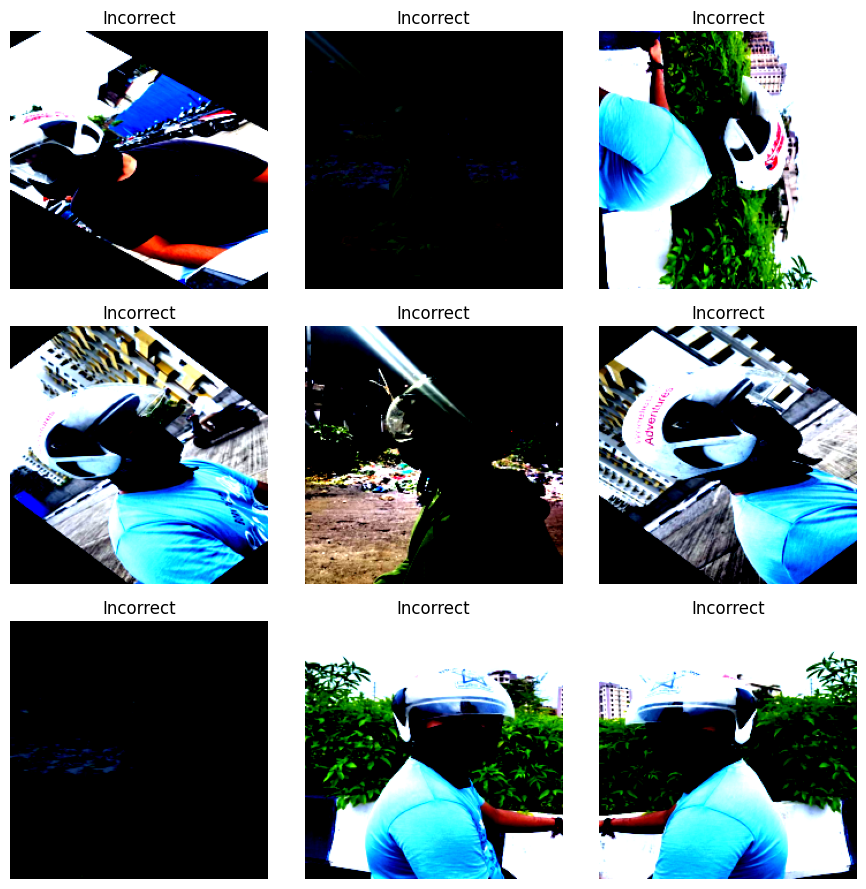

In [ ]:
example_imgs = []
example_lbls = []

for i in range(9):
    img, lbl = trainset[i]     # this applies transform → tensor
    example_imgs.append(img)
    example_lbls.append(lbl)

example_imgs = torch.stack(example_imgs)
example_lbls = torch.tensor(example_lbls)

show_batch(example_imgs, example_lbls)

# **Definition pre-trained model MobileNet**

In [ ]:
#set up model MobileNetV2 pretrained
import torch
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v2(pretrained=True)

model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

model = model.to(device)

print(model)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 66.8MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
#architecture model
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

# **Training**

In [ ]:
from tqdm.notebook import tqdm

def calculate_accuracy(y_pred, y):
    preds = y_pred.argmax(dim=1)
    correct = (preds == y).sum().item()
    total = y.size(0)
    return correct, total

def calculate_accuracy(y_pred, y):
    preds = y_pred.argmax(dim=1)
    correct = (preds == y).sum().float()
    total = y.size(0)
    return correct / total

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        #add code below
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()
        #add code above

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [ ]:
import time
import torch.optim as optim

def train_model(model, train_iterator, val_iterator, device,
                epochs=30,lr= 1e-3, model_path='best-model.pt'):

    model = model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_valid_loss = float('inf')

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for epoch in tqdm(range(epochs)):

        start_time = time.monotonic()

        train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(model, val_iterator, criterion, device)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_path)

        end_time = time.monotonic()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'valid_losses': valid_losses,
        'valid_accuracies': valid_accuracies,
        'best_model_path': model_path
    }

In [ ]:
stats = train_model(
    model=model,
    train_iterator=train_iterator,
    val_iterator=val_iterator,
    device=device
)

  0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 59s
	Train Loss: 0.343 | Train Acc: 85.62%
	 Val. Loss: 0.110 |  Val. Acc: 96.44%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 57s
	Train Loss: 0.198 | Train Acc: 92.55%
	 Val. Loss: 0.067 |  Val. Acc: 97.90%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 56s
	Train Loss: 0.186 | Train Acc: 93.25%
	 Val. Loss: 0.156 |  Val. Acc: 94.98%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 57s
	Train Loss: 0.159 | Train Acc: 94.15%
	 Val. Loss: 0.140 |  Val. Acc: 94.71%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 56s
	Train Loss: 0.132 | Train Acc: 95.37%
	 Val. Loss: 0.110 |  Val. Acc: 96.35%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 55s
	Train Loss: 0.104 | Train Acc: 96.41%
	 Val. Loss: 0.073 |  Val. Acc: 97.63%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 55s
	Train Loss: 0.129 | Train Acc: 95.94%
	 Val. Loss: 0.184 |  Val. Acc: 93.89%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 55s
	Train Loss: 0.119 | Train Acc: 95.83%
	 Val. Loss: 0.081 |  Val. Acc: 97.17%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 56s
	Train Loss: 0.076 | Train Acc: 97.26%
	 Val. Loss: 0.053 |  Val. Acc: 98.91%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 56s
	Train Loss: 0.080 | Train Acc: 97.26%
	 Val. Loss: 0.058 |  Val. Acc: 98.08%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 55s
	Train Loss: 0.061 | Train Acc: 97.88%
	 Val. Loss: 0.048 |  Val. Acc: 98.81%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 56s
	Train Loss: 0.106 | Train Acc: 96.08%
	 Val. Loss: 0.049 |  Val. Acc: 98.81%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 56s
	Train Loss: 0.067 | Train Acc: 97.67%
	 Val. Loss: 0.037 |  Val. Acc: 98.72%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 56s
	Train Loss: 0.038 | Train Acc: 98.92%
	 Val. Loss: 0.199 |  Val. Acc: 94.89%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 56s
	Train Loss: 0.047 | Train Acc: 98.35%
	 Val. Loss: 0.088 |  Val. Acc: 96.90%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 56s
	Train Loss: 0.055 | Train Acc: 98.16%
	 Val. Loss: 0.135 |  Val. Acc: 95.99%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 56s
	Train Loss: 0.045 | Train Acc: 98.74%
	 Val. Loss: 0.122 |  Val. Acc: 95.89%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 56s
	Train Loss: 0.043 | Train Acc: 98.32%
	 Val. Loss: 0.062 |  Val. Acc: 98.63%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 56s
	Train Loss: 0.029 | Train Acc: 98.92%
	 Val. Loss: 0.026 |  Val. Acc: 99.36%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 57s
	Train Loss: 0.062 | Train Acc: 98.28%
	 Val. Loss: 0.055 |  Val. Acc: 98.36%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 0m 57s
	Train Loss: 0.022 | Train Acc: 99.29%
	 Val. Loss: 0.067 |  Val. Acc: 98.72%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 0m 56s
	Train Loss: 0.046 | Train Acc: 98.49%
	 Val. Loss: 0.026 |  Val. Acc: 99.36%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 0m 56s
	Train Loss: 0.033 | Train Acc: 98.94%
	 Val. Loss: 0.043 |  Val. Acc: 98.72%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 0m 57s
	Train Loss: 0.041 | Train Acc: 98.77%
	 Val. Loss: 0.061 |  Val. Acc: 98.63%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 0m 56s
	Train Loss: 0.028 | Train Acc: 99.08%
	 Val. Loss: 0.050 |  Val. Acc: 98.91%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 0m 55s
	Train Loss: 0.020 | Train Acc: 99.51%
	 Val. Loss: 0.046 |  Val. Acc: 99.09%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: 0m 56s
	Train Loss: 0.043 | Train Acc: 98.59%
	 Val. Loss: 0.056 |  Val. Acc: 97.90%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 0m 57s
	Train Loss: 0.027 | Train Acc: 99.03%
	 Val. Loss: 0.064 |  Val. Acc: 98.27%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 29 | Epoch Time: 0m 56s
	Train Loss: 0.023 | Train Acc: 99.28%
	 Val. Loss: 0.036 |  Val. Acc: 99.18%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 0m 56s
	Train Loss: 0.066 | Train Acc: 97.84%
	 Val. Loss: 0.028 |  Val. Acc: 99.00%


# **Evaluation**

In [ ]:
model.load_state_dict(torch.load('best-model.pt'))
criterion = nn.CrossEntropyLoss().to(device)
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Test Loss: 0.036 | Test Acc: 99.27%


# **Confusion matrix**

In [ ]:
import numpy as np
import torch

def get_all_predictions(model, iterator, device):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in iterator:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            preds = y_pred.argmax(dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    return all_preds, all_labels

# get predictions and true labels
y_pred, y_true = get_all_predictions(model, test_iterator, device)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)


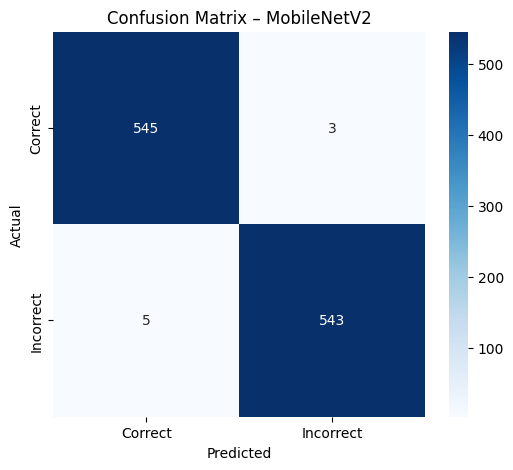

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Correct', 'Incorrect'],
            yticklabels=['Correct', 'Incorrect'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – MobileNetV2')
plt.show()

In [ ]:
TN, FP, FN, TP = cm.ravel()

# totals
total = TN + FP + FN + TP

# Accuracy
accuracy = (TP + TN) / total

# Precision / PPV
precision = TP / (TP + FP + 1e-8)

# Recall / Sensitivity / True Positive Rate
recall = TP / (TP + FN + 1e-8)

# Specificity / True Negative Rate
specificity = TN / (TN + FP + 1e-8)

# F1 Score
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

# False Positive Rate
fpr = FP / (FP + TN + 1e-8)

# False Negative Rate
fnr = FN / (FN + TP + 1e-8)

# Balanced Accuracy
balanced_accuracy = (recall + specificity) / 2

# Print values
print("---- Confusion Matrix Metrics ----")
print(f"Accuracy:            {accuracy*100:.2f}%")
print(f"Precision (PPV):     {precision*100:.2f}%")
print(f"Recall (Sensitivity):{recall*100:.2f}%")
print(f"Specificity (TNR):   {specificity*100:.2f}%")
print(f"F1 Score:            {f1*100:.2f}%")
print(f"False Pos. Rate:     {fpr*100:.2f}%")
print(f"False Neg. Rate:     {fnr*100:.2f}%")
print(f"Balanced Accuracy:   {balanced_accuracy*100:.2f}%")

---- Confusion Matrix Metrics ----
Accuracy:            99.27%
Precision (PPV):     99.45%
Recall (Sensitivity):99.09%
Specificity (TNR):   99.45%
F1 Score:            99.27%
False Pos. Rate:     0.55%
False Neg. Rate:     0.91%
Balanced Accuracy:   99.27%
